In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

nlp = spacy.load('en_core_web_lg')

2022-09-21 21:56:30.729333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 21:56:30.729350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/marko/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-21 21:56:33.123085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 21:56:33.123102: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 21:

In [2]:
# df.to_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")
df = pd.read_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")
df = df.head(80000)

In [245]:
#spajanje odvojenih postova

# df = df.groupby(['type', 'avgWordLen'], sort=False,as_index=False).agg({'posts':' '.join,'upperCount':'first','stopWordCount':'first','urlCount':'first','wordCount':'first','avgWordLen':'first','vectors':lambda x:np.array(x)})

In [3]:
#padding vektora
def paddingEmbedded(a):

  b = np.zeros([len(a), len(max(a, key=lambda x: len(x))),300])
  for i, j in enumerate(a):
    if(len(j)==0):
      continue
    b[i][0:len(j)] = j
    b[i][len(j):] = np.zeros(300,)
  return b

# df['vectors'] = df['vectors'].apply(lambda x: np.array(list(map(lambda y: y.reshape(300,), np.stack(x)))))

vectorList = paddingEmbedded(df['vectors'].array)

## NN ALGORITHMS

In [4]:
training_size = 0.8

sentences = []
labels = []

for ind in df.index:
    sentences.append(vectorList[ind])
    labels.append(df['type'][ind])

In [5]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size=1-training_size, random_state=42, stratify=labels)

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [7]:
encoder = OneHotEncoder()
training_labels = encoder.fit_transform(training_labels.reshape(-1,1)).toarray()
testing_labels = encoder.fit_transform(testing_labels.reshape(-1,1)).toarray()

In [8]:
# testing_sentences = np.array(list(testing_sentences))
# training_sentences = np.array(list(training_sentences))
testing_sentences = tf.convert_to_tensor(testing_sentences)
training_sentences = tf.convert_to_tensor(training_sentences)

2022-09-21 21:56:57.384912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 21:56:57.421547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728000000 exceeds 10% of free system memory.
2022-09-21 21:57:12.023109: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6912000000 exceeds 10% of free system memory.


In [9]:
classes = 4

filters = 32
pool_size = 2
kernel_size = 3

# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(500, activation='tanh'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(4, activation='softmax'),
# ])
model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid',activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size),
    tf.keras.layers.LSTM(120,return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(classes,activation='softmax')
])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [10]:
NEpoch = 10
batch_size = 32
history = model.fit(training_sentences, training_labels, batch_size=batch_size, epochs=NEpoch, validation_data=(testing_sentences, testing_labels))

Epoch 1/10
2000/2000 [==============================] - 48s 22ms/step - loss: 1.0598 - accuracy: 0.5112 - val_loss: 1.0513 - val_accuracy: 0.5173
Epoch 2/10
2000/2000 [==============================] - 48s 24ms/step - loss: 1.0510 - accuracy: 0.5169 - val_loss: 1.0474 - val_accuracy: 0.5202
Epoch 3/10
2000/2000 [==============================] - 43s 21ms/step - loss: 1.0468 - accuracy: 0.5220 - val_loss: 1.0462 - val_accuracy: 0.5225
Epoch 4/10
2000/2000 [==============================] - 50s 25ms/step - loss: 1.0438 - accuracy: 0.5238 - val_loss: 1.0488 - val_accuracy: 0.5241
Epoch 5/10
2000/2000 [==============================] - 43s 21ms/step - loss: 1.0420 - accuracy: 0.5255 - val_loss: 1.0441 - val_accuracy: 0.5220
Epoch 6/10
2000/2000 [==============================] - 43s 21ms/step - loss: 1.0386 - accuracy: 0.5285 - val_loss: 1.0439 - val_accuracy: 0.5237
Epoch 7/10
2000/2000 [==============================] - 43s 21ms/step - loss: 1.0365 - accuracy: 0.5300 - val_loss: 1.0450 -

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (32, 45, 300)             0         
                                                                 
 conv1d (Conv1D)             (32, 43, 32)              28832     
                                                                 
 max_pooling1d (MaxPooling1D  (32, 21, 32)             0         
 )                                                               
                                                                 
 lstm (LSTM)                 (32, 21, 120)             73440     
                                                                 
 global_average_pooling1d (G  (32, 120)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (32, 4)                   4

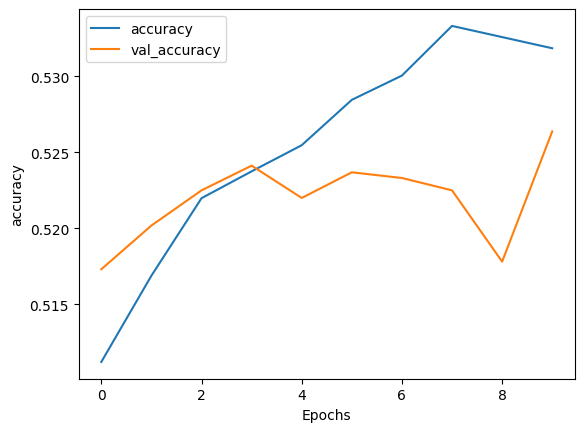

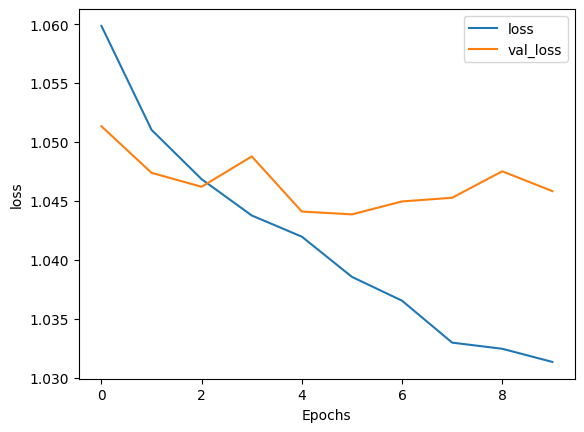

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_sentences[0]))
print(training_sentences[2])
print(labels[2])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [ ]:
sentence = ["I fully believe power protector voice voiceless so spirit I present film hope recieve spirit compassion om mani padme hum yes right but time help come outside relationshippartner supportive helpful I think get right help critical finding good if do not feel worthy love difference I think jawz I think indicative deep issue long meet it mean friend lookingglass thank make point unfortunately corrupt christianity speak loud voice still small voice forget very christian today this curse I get to tell people prefer remain stuck neurosis excuse of course spite scar I ve I know painful callie honestly I think dodged bullet I m sure he s good person sound emotional mature being involve you guy singe song I ve research heuristic mental shortcuts cognitive bias explain lot people for principle I empathize sentiment I think truly religion contain need society easily manipulate control this dualistic I think forget type make person emotional social competency past hurt issue value meme etc I see experiment crowd I do not feel rare I feel thank uk sound like reasonable compassionate person I think neitzsche quote beware fight monster lest process appropriate here colorado it surprise learn cognitive brain science discover human actually hard - wire empathy read golemans social intelligence help understand you understand aegis blame yes like inhuman monster try justify marginalize human people like do not understand you know idea riddle fallacy linquistic manipulation is not worth time continue conversation hopefully year pass learn think an elephant swallow boa constrictor love book I cry little end thoughtful philosophy sure I like line the little prince signature block I use accord logic tolerance accept intolerance consider tolerant homosexuality violent behavior conflate extremely okay guy record I think healthy debate help forward simple heuristic accompany cognitive bias prevalent religion critical thinking look like explain I m sorry I do not notice post do not mean ignore the teleological argument definitely major flaw conclusion draw okay attribute else quote second problem this post logical fallacy introduce straw - man no problem look light moment re - frame argument no introduce idea tolerant clever use slippery slope do not blame touch gay marriage good I far faith reason inherently contradictory I word post way I you understand I spend life study religion no suppose know inner council can not people aware communicate telepathically year disguise regular folk so get decide good and I would not word like logic religion concern little religion stand critical inquiry old school infj theme song veteran psychic war blue oyster cult okay world bullshit I m go to change frame reference up point I ve operate think world vampire define get olderfor life I try squeeze role I think I need order I think people know like you plate pardner pretty typical ill bet stuff go inside reasonably articulate this I love I like card do not write creative after argument wife I find little dog I write run away love thread over year I practice religion philosophy I think infj mean explorer extent during phase exploration I practice I think I hate crap meaningless usually people feel good the truth people self - center do not understand love I understand it bother lot I walk store feel angry judgmental add sap energy feeling I do not like the great sage linus van pelt say I love mankind people I can not stand I find end individually I love people group funny come long way sometimes I try talk like oh man do not know sure chance come accord cognitive brain science truly tune human synchrony brain wave with discovery mirror neuron look like stumble buddhist first noble truth okay I m go to sound lame go you go find keep change grow nature ever try friend stray cat the rule apply do not chase run provide safe friendly harbor watch quickly affectionate well like someones post thank un thank thank oh chazz that feeling come go I would not mean ever I remember I feel like I belong as child I impression presence okay totally agree post I could not help get visual intimidate typist I see roz monsters inc it take little time tell difference anxious perception clear intuition that say year I manage screw royally time great movie I think movie move wing of desire this film old school style direct wim wender feature talent I m sure experience maybe I m middle aged I thing way I musician artist salesman soldier nurse cna technician christian buddhist I find mirror neuron read daniel golemans social intelligence credit research go italian research scientist escape ai not funive reading mirror neuron genuinely engage human brain actually sync now have compile information link mb type soma type I wonder expectation little unrealistic time sometimes I feel emotionally raw wound need withdraw oddly time like little",
            "I m currently root forum look place rant I think thread good I friend ask bunch event stuff I I get reformer vdi - s nature visionary tactic diligent energy introvert identity support interesting -- thank bring attention but everyone mom isfj rolleyes oh hey inregardstomyself how today ask friend huh are ask bff rise wink I look -isfj big lurker how I recognize fe I care sooo thing happen affect people feeling I want sure feel okay time my most - use phrase after break - up I need space no contact ex -- polite distance time I need turn attention life regain energy sense hope purpose I ve I ve experience struggle right life assertive overwhelmed conflict stress uncertainty future I m deal I want youtubecom angel olsen album burn your fire no witness blush I read go thank learn I thank rolleyes hehe I ve decluttere reorganize closet space storage box past this rant isfj who s try find right sort person date settle erm I my romantic relationship nf type I I ve know wheeze laughter beverage case brother time soup come nose yes this I readingoutnumbersworld I m like anecdotally life no I surround n I appreciate bring way I want I appreciate thread this stuff I spend lot time thinking try figure helpful read perspective isfj haaalp assume severely censor upbringing infjs generally happy share feeling perspective in fact give right opportunity infjs I m sensitive hearing criticism direct hear people level lot criticism wear type when testy support genuine reassurance ease anxiety try win argument this accurate just week I discover I isfjs cuuute favorite musician kaki king mini golf mountain I cat indigo we hang sure ill bite what s ageage range year young where locate city state country region tennessee usa what s current occupationjobcareer admin the album dopamine brn are overwhelmed possible thing I refer laugh I mean like I m work sudden different request come is feel easily overwhelmed kate bushs the dream youtube I love you ve post recently about sense people able translate sense valid argument -- yes omg yes I I attest statement healthy infjs express love challenge emotional exhaustion I ve relationship infj moderate introversion its I ve long flight on short one I read book entire time zone thinkdaydream I usually travel I do not know who oh I do not question I pop I m romantic relationship infj amazing she s amazing proud carry friend aw man I want like slothpop its okay I annoy xsfjs off topic I appreciate post type forum feel equal haha you know you re intj doubt people claim intj fact intj it popular type talk I confirm my mind boggle right where supposedly common sensor almost everyoneim start think interest relevant big dear isfp you good friend I love sooo sorry sorry mushy today kitteh love isfj when friend different part life table enjoy company feel highest delight have bring my thought I bet angelcat reply do not drink I girl tongue good stay trouble I think honestly I absolutely no idea type I good romantic relationship I ve date infp enfj difficult difference usually fairly happy I sad depend emotional state go verrry chatty any thought I ve carefully suppress urge loud people people make statement memy personality especially group set like know do not one coworker say you re intj want work I prime see angelcat comment yeah the bmw I like sedan kind sporty quote haha funny reply thatkillsme when I join perc avatar cute little chameleon I morph gentle young stag ugh double - post thank yeah I wonder right signing class helpful actually I organize information plot day long actually help thing write in everyone response sound fun this summer I m go bit travel couple place I ve continue reach people develop friendship continue work hang type comparatively I like pessimistic grumpus around I good social skill how I perceive change depend I m shoegaze yesss good stuff my friend introduce song like youtube it appear arrive spring I m sure shortly welp photo isfj it snow late february early march year snow day rare I live silly so dainty thank whateverlolawant that s interesting I date infp move fast I actually think kind gray area tell then I like label thing people box I know feel limit give sense order peace mind I do not listen pop music I pretty particular taste I like lot ambient music -- music act soundtrack thought world I m drive walk and I so I get romantic relationship I ve datedpeople total life relationship end person find new date I I"]
embedded = []
for string in sentence:
  embedded.append(word2vec(string))
embedded = np.array(embedded)
print(model.predict(embedded))
## correct is
## [2]
## [0]